In [1]:
import pyro
import torch
import wandb
import os

import numpy as np

from pyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, init_to_mean
from inference.bayesian.models import TorchModel, BayesianModel
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [512, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "num_samples": 1000,
            "inference": "svi",
            "lr": 0.00087,
            "num_iterations": 2000,
            "plot": True,
            "sweep": False
            }

os.environ["WANDB_MODE"]="offline"
os.environ["WANDB_NOTEBOOK_NAME"]="main_svi.ipynb"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding, diffXte, diffYte = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 10428, Val: 5214, Te: 5214


# SVI

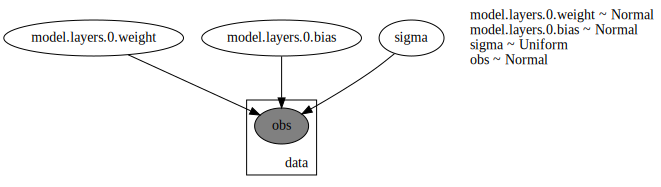

In [4]:
torch_model = TorchModel(config.model_widths, config.activation).to(device)
svi_model = BayesianModel(torch_model, config, device)
svi_model.render_model(model_args=(train_embedding[0], Ytr[0]))

Autoguide for testing

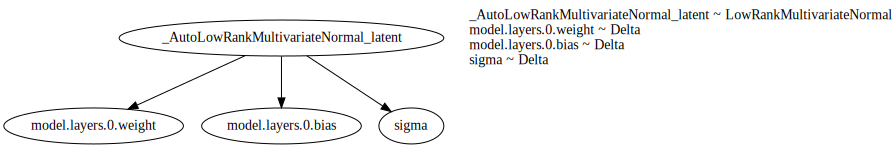

In [5]:
pyro.clear_param_store()

# To enforce all the parameters in the guide on the GPU, since we use an autoguide
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

guide = AutoLowRankMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
# A full multivariate normal saturates gpu memory, the covariance matrix is too big
# guide = AutoMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding[0], Ytr[0]), render_distributions=True)

In [6]:
for n, p in pyro.get_param_store().items():
    print(f"{n}, shape: {p.shape}")

AutoMultivariateNormal.loc, shape: torch.Size([514])
AutoMultivariateNormal.scale, shape: torch.Size([514])
AutoMultivariateNormal.scale_tril, shape: torch.Size([514, 514])


In [6]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [7]:
predictive, diagnostics = inference(config, svi_model, guide,
                                    X_train=train_embedding, Y_train=Ytr,
                                    X_val=val_embedding, Y_val=Yval, 
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

Epoch 2000: 100%|██████████| 2000/2000 [00:41<00:00, 47.80it/s, loss=1.62]


<Figure size 600x600 with 0 Axes>

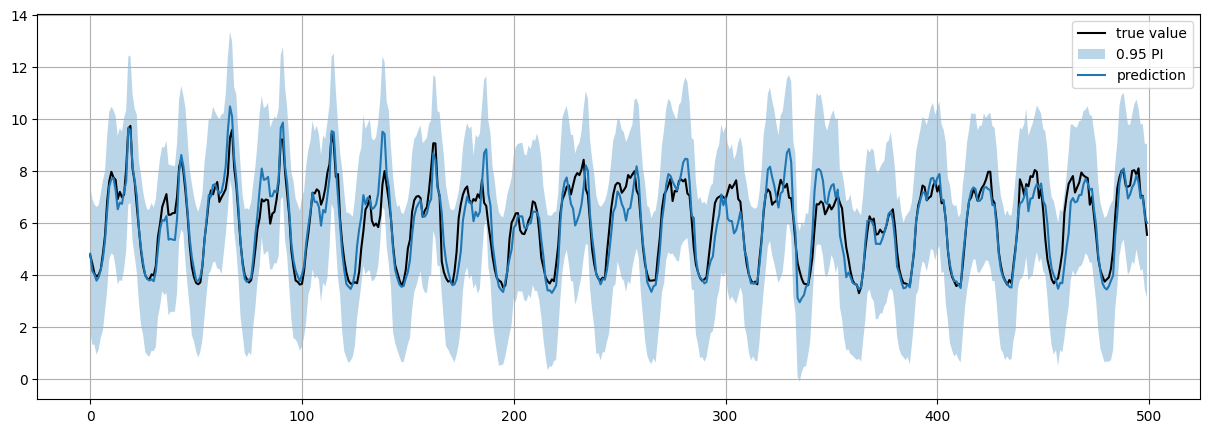

In [8]:
CI = [diagnostics["quantiles"][2], diagnostics["quantiles"][-2]]

plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), CI, "svi", 500)

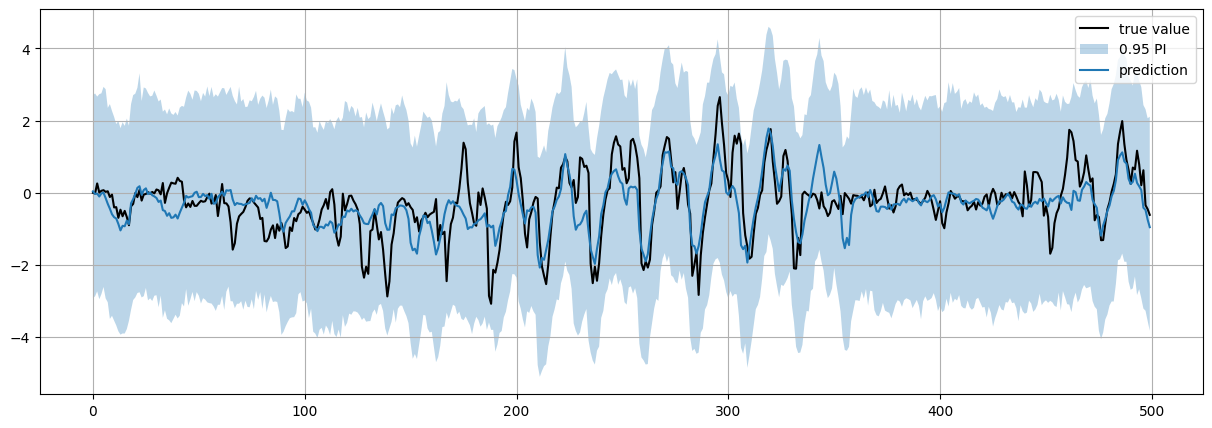

In [9]:
plot_forecast(predictive, torch.concat([torch.zeros(1), Yte[:-1]]), np.zeros_like(diffXte.squeeze()), np.zeros_like(diffYte.squeeze()), CI, "svi", 500)

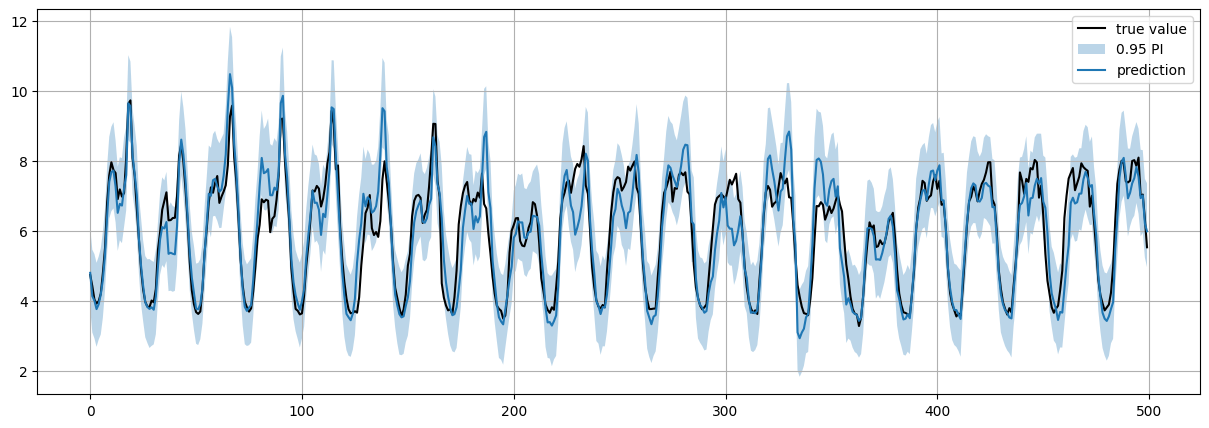

In [10]:
CI = [diagnostics["new_quantiles"][2], diagnostics["new_quantiles"][-2]]

plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), CI, "svi", 500)

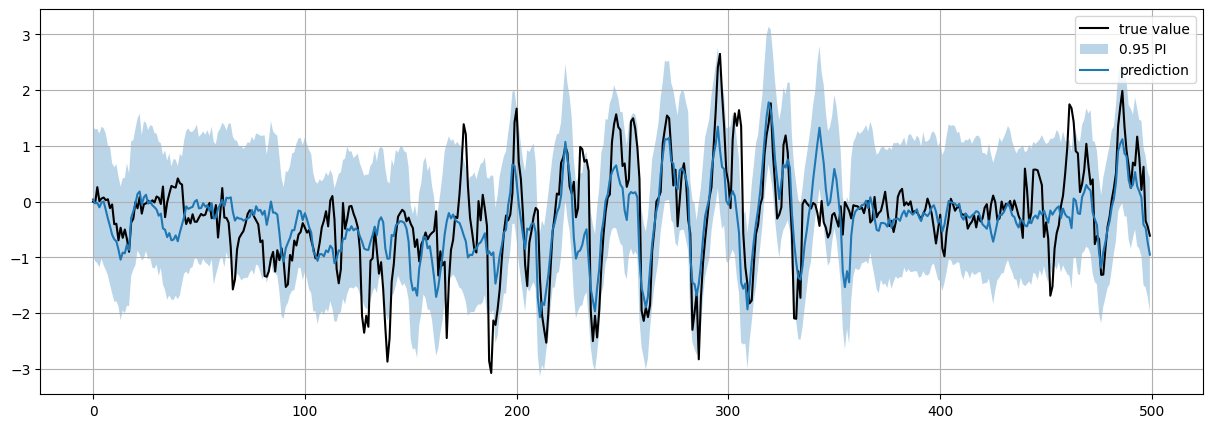

In [11]:
plot_forecast(predictive, torch.concat([torch.zeros(1), Yte[:-1]]), np.zeros_like(diffXte.squeeze()), np.zeros_like(diffYte.squeeze()), CI, "svi", 500)

In [12]:
for k, v in diagnostics.items():
    print(k, "\t", v)

train_time 	 6.984375
final_loss 	 1.6154733416526126
inference_time 	 2.84375
cal_error 	 1.1058937343530422
new_cal_error 	 0.011287893126248732
quantiles 	 [0, 0.005, 0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4, 0.42500000000000004, 0.45, 0.47500000000000003, 0.5, 0.525, 0.55, 0.5750000000000001, 0.6000000000000001, 0.625, 0.65, 0.675, 0.7000000000000001, 0.7250000000000001, 0.75, 0.775, 0.8, 0.8250000000000001, 0.8500000000000001, 0.875, 0.9, 0.925, 0.9500000000000001, 0.9750000000000001, 0.995]
new_quantiles 	 [0.         0.05847917 0.22966912 0.30341837 0.34945833 0.38584615
 0.40672393 0.42216825 0.43523558 0.44776923 0.45699413 0.46550261
 0.4740111  0.48051724 0.48676006 0.49300287 0.49924569 0.50427612
 0.50913993 0.51400373 0.51886754 0.52373134 0.52874611 0.53381415
 0.53888219 0.54395023 0.54901827 0.55503352 0.56127634 0.56751916
 0.57376197 0.5

In [ ]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')